In [1022]:
import pandas as pd 
import numpy as np 

In [1023]:
## Load the dataset
df = pd.read_csv("../Bank loan eligibility prediction/train_u6lujuX_CVtuZ9i.csv")
df.tail()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y
613,LP002990,Female,No,0,Graduate,Yes,4583,0.0,133.0,360.0,0.0,Semiurban,N


In [1024]:
# Dropping unnecessary columns
df = df.drop('Loan_ID', axis=1)

In [1025]:
# Check for missing values
df.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

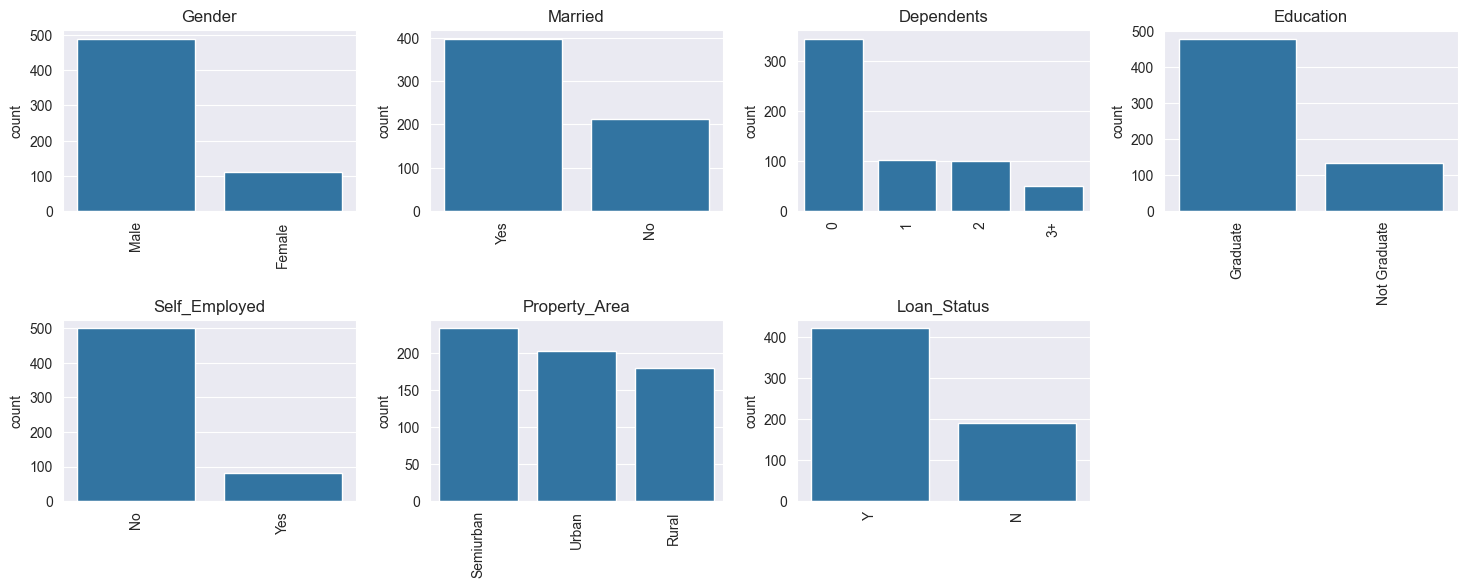

In [1026]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of categorical features
sns.set_style('darkgrid')
sns.set_palette('tab10')

obj = (df.dtypes == 'object')
categorical_cols = list(obj[obj].index)
plt.figure(figsize=(18, 40))
index = 1

for col in categorical_cols:
    y = df[col].value_counts()
    plt.subplot(11, 4, index)
    plt.xticks(rotation=90)
    plt.subplots_adjust(hspace=0.6, wspace=0.25) 
    sns.barplot(x = list(y.index), y = y).set_title(col)
    index += 1


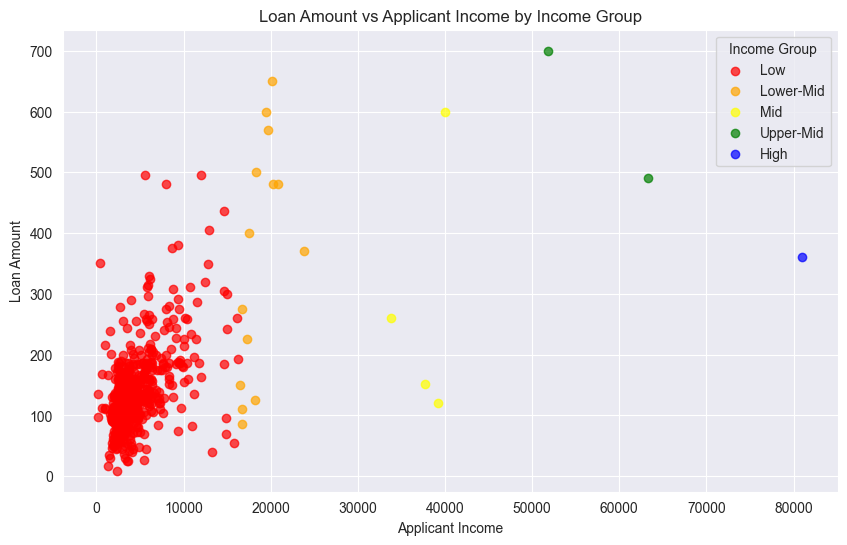

In [1027]:
# Comparing the LoanAmount With the ApplicantIncome
df['IncomeGroup'] = pd.cut(df['ApplicantIncome'], bins=5, labels=['Low', 'Lower-Mid', 'Mid', 'Upper-Mid', 'High'])

color = {
    'Low': 'red',
    'Lower-Mid': 'orange',
    'Mid': 'yellow',
    'Upper-Mid': 'green',
    'High': 'blue'  
}

plt.figure(figsize=(10, 6))

for group in df['IncomeGroup'].unique():
    group_data = df[df['IncomeGroup'] == group]
    plt.scatter(group_data['ApplicantIncome'], group_data['LoanAmount'],
                 color=color[group], label=group, alpha=0.7)
                 
plt.xlabel('Applicant Income')
plt.ylabel('Loan Amount')
plt.title('Loan Amount vs Applicant Income by Income Group')
plt.legend(title='Income Group')
plt.grid(True)
plt.show()


In [1059]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Pandas Profiling report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 467.02it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [1060]:
# Check the data types of the columns
df.dtypes

Gender                 object
Married                object
Dependents             object
Education              object
Self_Employed          object
ApplicantIncome         int64
CoapplicantIncome     float64
LoanAmount            float64
Loan_Amount_Term      float64
Credit_History        float64
Property_Area          object
Loan_Status            object
IncomeGroup          category
dtype: object

In [1061]:
df['Property_Area'].unique()

array(['Urban', 'Rural', 'Semiurban'], dtype=object)

In [1062]:
# Check the Object columns in the dataset
df.select_dtypes(include=['object']).columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area', 'Loan_Status'],
      dtype='object')

In [1063]:
# Check the Numeric columns in the dataset
df.select_dtypes(include=['int64', 'float64']).columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')

In [1064]:
# Separate features (X) and target variable (y)
x = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

In [1065]:
# Convert categorical variables to numerical using one-hot encoding
num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
            'Loan_Amount_Term', 'Credit_History']
cat_cols = ['Gender', 'Married', 'Dependents', 'Education',
             'Self_Employed', 'Property_Area']

In [1066]:
print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)
print("Total columns:", len(num_cols) + len(cat_cols))


Numeric columns: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
Categorical columns: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
Total columns: 11


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

np.random.seed(42)

imputer = ColumnTransformer([
    ('num_imputer', SimpleImputer(strategy='mean'), num_cols),
    ('cat_imputer', SimpleImputer(strategy='most_frequent'), cat_cols)
    ],remainder='drop')

def add_features(x_df):
    x = x_df.copy()
    x['LoanAmount'] = x['LoanAmount'].fillna(0)
    x['TotalIncome'] = x['ApplicantIncome'] + x['CoapplicantIncome']
    x['EMI'] = x['LoanAmount'] / x['Loan_Amount_Term'].replace(0, 1)
    x['LoanAmount_log'] = np.log1p(x['LoanAmount'])
    return x

fe = FunctionTransformer(add_features)

categorical_features = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area']
le = LabelEncoder()
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
transformed = ColumnTransformer(
     transformers =  [("onehot_encoder",
                       onehot_encoder,
                         categorical_features)],
                           remainder='passthrough')

new_features = ['TotalIncome', 'EMI']
all_cols = num_cols + cat_cols + new_features

dt_model = Pipeline(steps=[
    ('imputer', imputer),
    ('to_df', FunctionTransformer(lambda arr:
        pd.DataFrame(arr, columns= num_cols + cat_cols))),  
    ('fe', fe),     
    ('encoder', transformed),
    ('model', DecisionTreeClassifier(
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=4,
        random_state=42,
    )),
    ])

rf_model = Pipeline(steps=[
    ('imputer', imputer),
    ('to_df', FunctionTransformer(lambda arr:
        pd.DataFrame(arr, columns= num_cols + cat_cols))),  
    ('fe', fe),     
    ('encoder', transformed),
    ('model', RandomForestClassifier(
    max_depth=3,
    min_samples_split=4,
    min_samples_leaf=5,
    random_state=42)),
    ])

log_r_model = Pipeline(steps=[
    ('imputer', imputer),
    ('to_df', FunctionTransformer(lambda arr:
        pd.DataFrame(arr, columns= num_cols + cat_cols))),  
    ('fe', fe),     
    ('encoder', transformed),
    ('model', LogisticRegression()),
    ])

svc_model = Pipeline(steps=[
    ('imputer', imputer),
    ('to_df', FunctionTransformer(lambda arr:
        pd.DataFrame(arr, columns= num_cols + cat_cols))),  
    ('fe', fe),     
    ('encoder', transformed),
    ('model', SVC()),
    ])

xboost_model = Pipeline(steps=[
    ('imputer', imputer),
    ('to_df', FunctionTransformer(lambda arr:
        pd.DataFrame(arr, columns= num_cols + cat_cols))),  
    ('fe', fe),     
    ('encoder', transformed),
    ('model', XGBClassifier(
        colsample_bytree = 0.9,
        max_depth = 3,
        min_child_weight = 10,
        n_estimators = 100,
        subsample = 0.9,
    )),
    ])


x = df.drop('Loan_Status', axis=1)
y = le.fit_transform(df['Loan_Status'])


In [1068]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


param_grid_dt = {
    'model__max_depth': [3, 5, 7, 10],  
    'model__min_samples_split': [5, 10, 20],  
    'model__min_samples_leaf': [2, 4, 5],  
    'model__max_features': [None, 'sqrt', 'log2']  
}

grid_search_dt = GridSearchCV(
    estimator=dt_model,
      param_grid=param_grid_dt,
        cv=5,
          scoring = 'f1',
          n_jobs=1)

grid_search_dt.fit(x_train, y_train)
best_model_dt = grid_search_dt.best_estimator_
print("Best parameters for Decision Tree:", grid_search_dt.best_params_)

param_grid_rf = {
    'model__n_estimators': [100, 150],
    'model__max_depth': [3, 4, 5],
    'model__min_samples_split': [5, 10],
    'model__min_samples_leaf': [2, 4],
}

grid_search = GridSearchCV(
    estimator=rf_model,
      param_grid=param_grid_rf,
        cv=5,
          scoring = 'f1')

grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
print("Best parameters for Random forest:", grid_search.best_params_)

param_grid_xgboost = {
    'model__n_estimators': [100, 150, 200],
    'model__max_depth': [3, 5, 7],
    'model__min_child_weight': [1, 5, 10],
    'model__subsample': [0.7, 0.8, 0.9],
    'model__colsample_bytree': [0.7, 0.8, 0.9]
}
grid_search_xgboost = GridSearchCV(
    estimator=xboost_model,
      param_grid=param_grid_xgboost,
        cv=5,
          scoring = 'f1',
          n_jobs=1)

grid_search_xgboost.fit(x_train, y_train)
best_model_xgboost = grid_search_xgboost.best_estimator_
print("Best parameters for XGBoost:", grid_search_xgboost.best_params_)


# cv_scores = cross_val_score(pipeline, x_train, y_train, cv=5)

# print(f"Cross-validation scores: {cv_scores}")
# print(f"Mean cross-validation score: {cv_scores.mean()}")

C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)
C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)
C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To o

Best parameters for Decision Tree: {'model__max_depth': 3, 'model__max_features': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5}


C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)
C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)
C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To o

Best parameters for Random forest: {'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5, 'model__n_estimators': 100}


C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)
C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)
C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To o

Best parameters for XGBoost: {'model__colsample_bytree': 0.9, 'model__max_depth': 3, 'model__min_child_weight': 10, 'model__n_estimators': 100, 'model__subsample': 0.9}


C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)
C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)


In [1069]:
print(x_train.columns)
print(x_test.columns)

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'IncomeGroup'],
      dtype='object')
Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'IncomeGroup'],
      dtype='object')


In [1070]:
print("The decisiontree score:")

dt_model.fit(x_train, y_train)
y_proba = dt_model.predict_proba(x_test)[:, 1]
threshold = 0.3
y_pred = (y_proba >= threshold).astype(int)
dt_model.score(x_test, y_test)

The decisiontree score:


C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)
C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)
C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To o

0.7560975609756098

In [1071]:
y_pred = dt_model.predict(x_test)
y_pred

C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1])

In [1072]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.44      0.56        43
           1       0.76      0.93      0.83        80

    accuracy                           0.76       123
   macro avg       0.76      0.68      0.70       123
weighted avg       0.76      0.76      0.74       123



In [1073]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.7560975609756098
Precision: 0.7551020408163265
Recall: 0.925
F1 Score: 0.8314606741573034


In [1074]:
y_train_pred = dt_model.predict(x_train)

# Predictions on the test set
y_test_pred = dt_model.predict(x_test)

# Training set performance
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Test set performance
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Print the results
print("Training Set Performance:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")

print("\nTest Set Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1}")


C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)
C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)


Training Set Performance:
Accuracy: 0.8431771894093686
Precision: 0.8320802005012531
Recall: 0.9707602339181286
F1 Score: 0.8960863697705803

Test Set Performance:
Accuracy: 0.7560975609756098
Precision: 0.7551020408163265
Recall: 0.925
F1 Score: 0.8314606741573034


In [1075]:
print("The RandomForest score:")
rf_model.fit(x_train, y_train)
y_proba = rf_model.predict_proba(x_test)[:, 1]
threshold = 0.3
y_pred = (y_proba >= threshold).astype(int)
rf_model.score(x_test, y_test)

C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)


The RandomForest score:


C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)
C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)


0.7886178861788617

In [1076]:
print(classification_report(y_test, y_pred))

c:\Users\moham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\moham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\moham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.65      1.00      0.79        80

    accuracy                           0.65       123
   macro avg       0.33      0.50      0.39       123
weighted avg       0.42      0.65      0.51       123



In [1077]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.6504065040650406
Precision: 0.6504065040650406
Recall: 1.0
F1 Score: 0.7881773399014779


In [1078]:
y_train_pred = rf_model.predict(x_train)

# Predictions on the test set
y_test_pred = rf_model.predict(x_test)

# Training set performance
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Test set performance
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Print the results
print("Training Set Performance:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")

print("\nTest Set Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1}")


Training Set Performance:
Accuracy: 0.8167006109979633
Precision: 0.7985781990521327
Recall: 0.9853801169590644
F1 Score: 0.8821989528795812

Test Set Performance:
Accuracy: 0.7886178861788617
Precision: 0.7596153846153846
Recall: 0.9875
F1 Score: 0.8586956521739131


C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)
C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)


In [1079]:
print("The Logistic Regression score:")

log_r_model.fit(x_train, y_train)
y_proba = log_r_model.predict_proba(x_test)[:, 1]
threshold = 0.3
y_pred = (y_proba >= threshold).astype(int)
log_r_model.score(x_test, y_test)

C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)


The Logistic Regression score:


c:\Users\moham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)
C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarn

0.7642276422764228

In [1080]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.30      0.46        43
           1       0.72      0.99      0.84        80

    accuracy                           0.75       123
   macro avg       0.83      0.64      0.65       123
weighted avg       0.80      0.75      0.70       123



In [1081]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.7479674796747967
Precision: 0.7247706422018348
Recall: 0.9875
F1 Score: 0.8359788359788359


In [1082]:
y_train_pred = log_r_model.predict(x_train)

# Predictions on the test set
y_test_pred = log_r_model.predict(x_test)

# Training set performance
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Test set performance
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Print the results
print("Training Set Performance:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")

print("\nTest Set Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1}")


Training Set Performance:
Accuracy: 0.8167006109979633
Precision: 0.8073170731707318
Recall: 0.9678362573099415
F1 Score: 0.8803191489361702

Test Set Performance:
Accuracy: 0.7642276422764228
Precision: 0.7428571428571429
Recall: 0.975
F1 Score: 0.8432432432432433


C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)
C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)


In [1083]:
print("The Support vector classifier  score:")

svc_model.fit(x_train, y_train)
y_pred = svc_model.predict(x_test)
svc_model.score(x_test, y_test)

C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)
C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)
C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To o

The Support vector classifier  score:


0.6504065040650406

In [1084]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.65      1.00      0.79        80

    accuracy                           0.65       123
   macro avg       0.33      0.50      0.39       123
weighted avg       0.42      0.65      0.51       123



c:\Users\moham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\moham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\moham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [1085]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.6504065040650406
Precision: 0.6504065040650406
Recall: 1.0
F1 Score: 0.7881773399014779


In [1086]:
y_train_pred = svc_model.predict(x_train)

# Predictions on the test set
y_test_pred = svc_model.predict(x_test)

# Training set performance
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Test set performance
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Print the results
print("Training Set Performance:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")

print("\nTest Set Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1}")


C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)


Training Set Performance:
Accuracy: 0.7026476578411406
Precision: 0.7008196721311475
Recall: 1.0
F1 Score: 0.8240963855421687

Test Set Performance:
Accuracy: 0.6504065040650406
Precision: 0.6504065040650406
Recall: 1.0
F1 Score: 0.7881773399014779


C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)


In [1087]:
print("The XGBClassifier score:")

xboost_model.fit(x_train, y_train)
y_proba = xboost_model.predict_proba(x_test)[:, 1]
threshold = 0.3
y_pred = (y_proba >= threshold).astype(int)
xboost_model.score(x_test, y_test)

C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)


The XGBClassifier score:


C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)
C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)


0.7642276422764228

In [1088]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.35      0.49        43
           1       0.73      0.96      0.83        80

    accuracy                           0.75       123
   macro avg       0.78      0.66      0.66       123
weighted avg       0.77      0.75      0.71       123



In [1089]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.7479674796747967
Precision: 0.7333333333333333
Recall: 0.9625
F1 Score: 0.8324324324324325


In [1090]:
y_train_pred = xboost_model.predict(x_train)

# Predictions on the test set
y_test_pred = xboost_model.predict(x_test)

# Training set performance
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Test set performance
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Print the results
print("Training Set Performance:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")

print("\nTest Set Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1}")


C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)
C:\Users\moham\AppData\Local\Temp\ipykernel_31640\4035466354.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['LoanAmount'] = x['LoanAmount'].fillna(0)


Training Set Performance:
Accuracy: 0.890020366598778
Precision: 0.8850267379679144
Recall: 0.9678362573099415
F1 Score: 0.9245810055865922

Test Set Performance:
Accuracy: 0.7642276422764228
Precision: 0.7628865979381443
Recall: 0.925
F1 Score: 0.8361581920903954


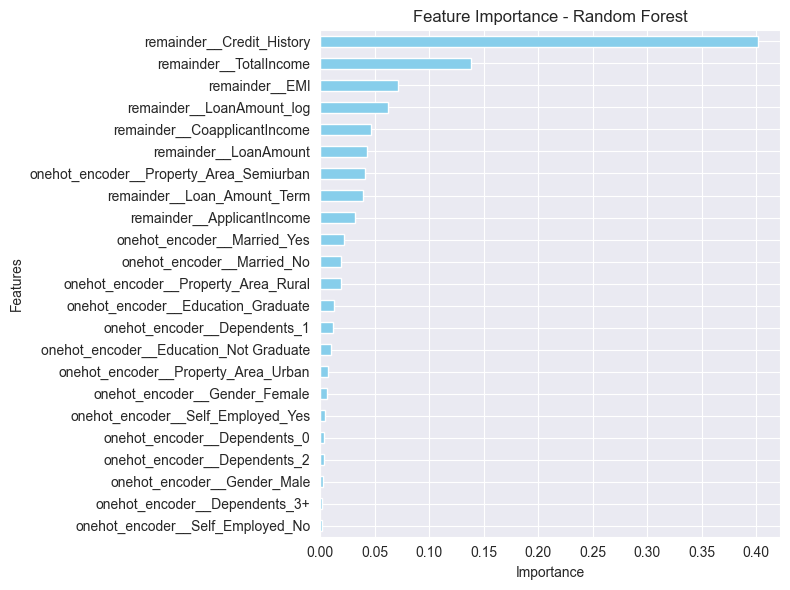

In [1094]:
# Get the trained RandomForestClassifier from the pipeline
rf_classifier = rf_model.named_steps['model']  # change 'model' if your step is named differently

# Now this will work
importances = pd.Series(rf_classifier.feature_importances_, index=cleaned_feature_names)
importances = importances.sort_values()

# Plot
plt.figure(figsize=(8, 6))
importances.plot(kind="barh", color="skyblue")
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()
